In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')

# Data Analyst

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#counting number of images of each actor

def count_files_in_subdirs(directory, set_name):

    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Create a DataFrame from the dictionary.
    df = pd.DataFrame(list(counts.items()), columns=['Actor', 'Number of Images'])

    # Set the 'Actor' column as the index and name it using 'set_name'.
    df.set_index('Actor', inplace=True)
    df.index.name = set_name

    return df

# Path to the directory containing the images.
image_dir = ('/content/drive/MyDrive/dataset/Original Images/Original Images/')

# Count the files in the subdirectories and print the result.
count_df = count_files_in_subdirs(image_dir,'images')
print(count_df)

                    Number of Images
images                              
Tom Cruise                        58
Zac Efron                         91
Virat Kohli                       49
Vijay Deverakonda                115
Robert Downey Jr                 113
Priyanka Chopra                  102
Margot Robbie                     72
Natalie Portman                  105
Roger Federer                     77
Marmik                            32
Hrithik Roshan                   101
Ellen Degeneres                   75
Henry Cavill                     106
Kashyap                           30
Jessica Alba                     108
Courtney Cox                      80
Elizabeth Olsen                   71
Hugh Jackman                     112
Lisa Kudrow                       70
Dwayne Johnson                    61
Camila Cabello                    87
Brad Pitt                        120
Andy Samberg                      92
Anushka Sharma                    68
Amitabh Bachchan                  74
B

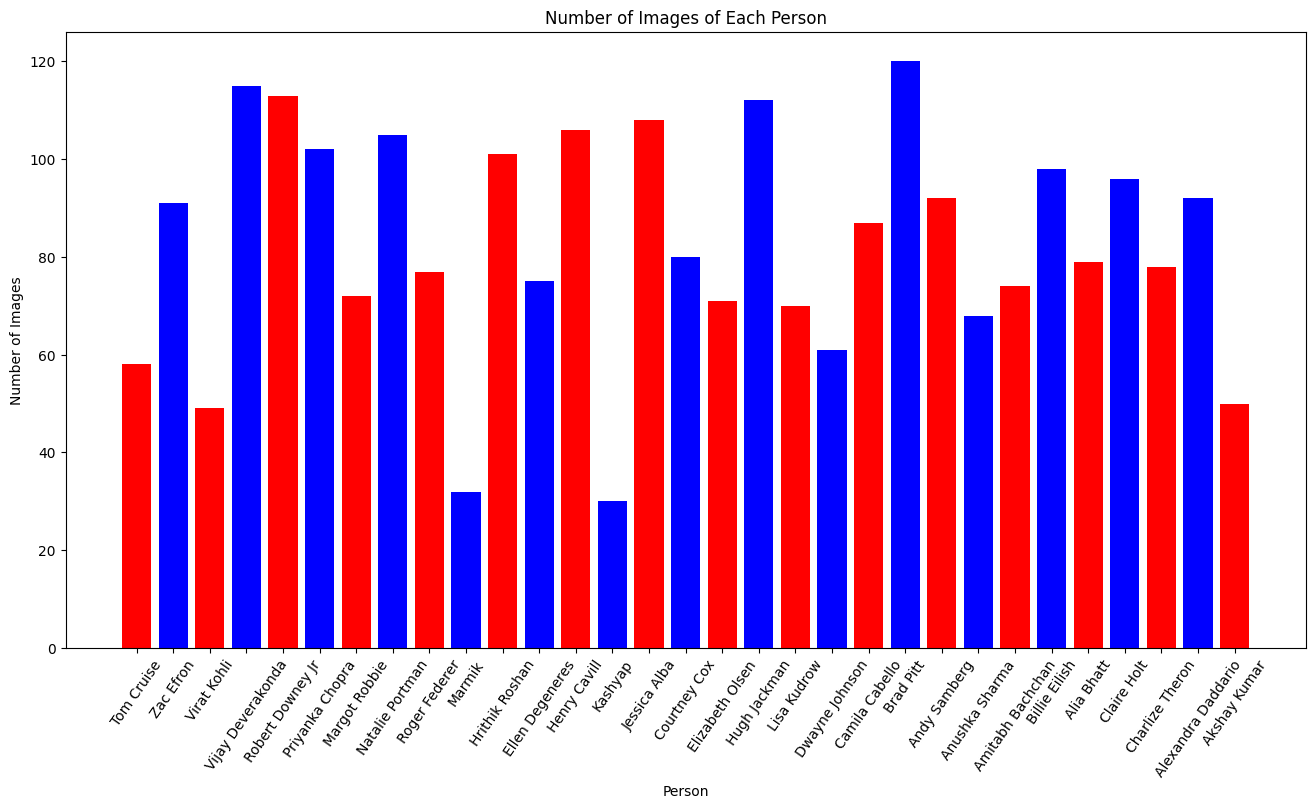

In [ ]:
count_df=count_df.reset_index()
actors=count_df['images']
count=count_df['Number of Images']

plt.figure(figsize=(16,8))

plt.bar(actors, count,color=['r','b'])

plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('Number of Images of Each Person')

plt.xticks(rotation=55)  # Rotate x-axis labels for better readability if there are many actors
plt.show()

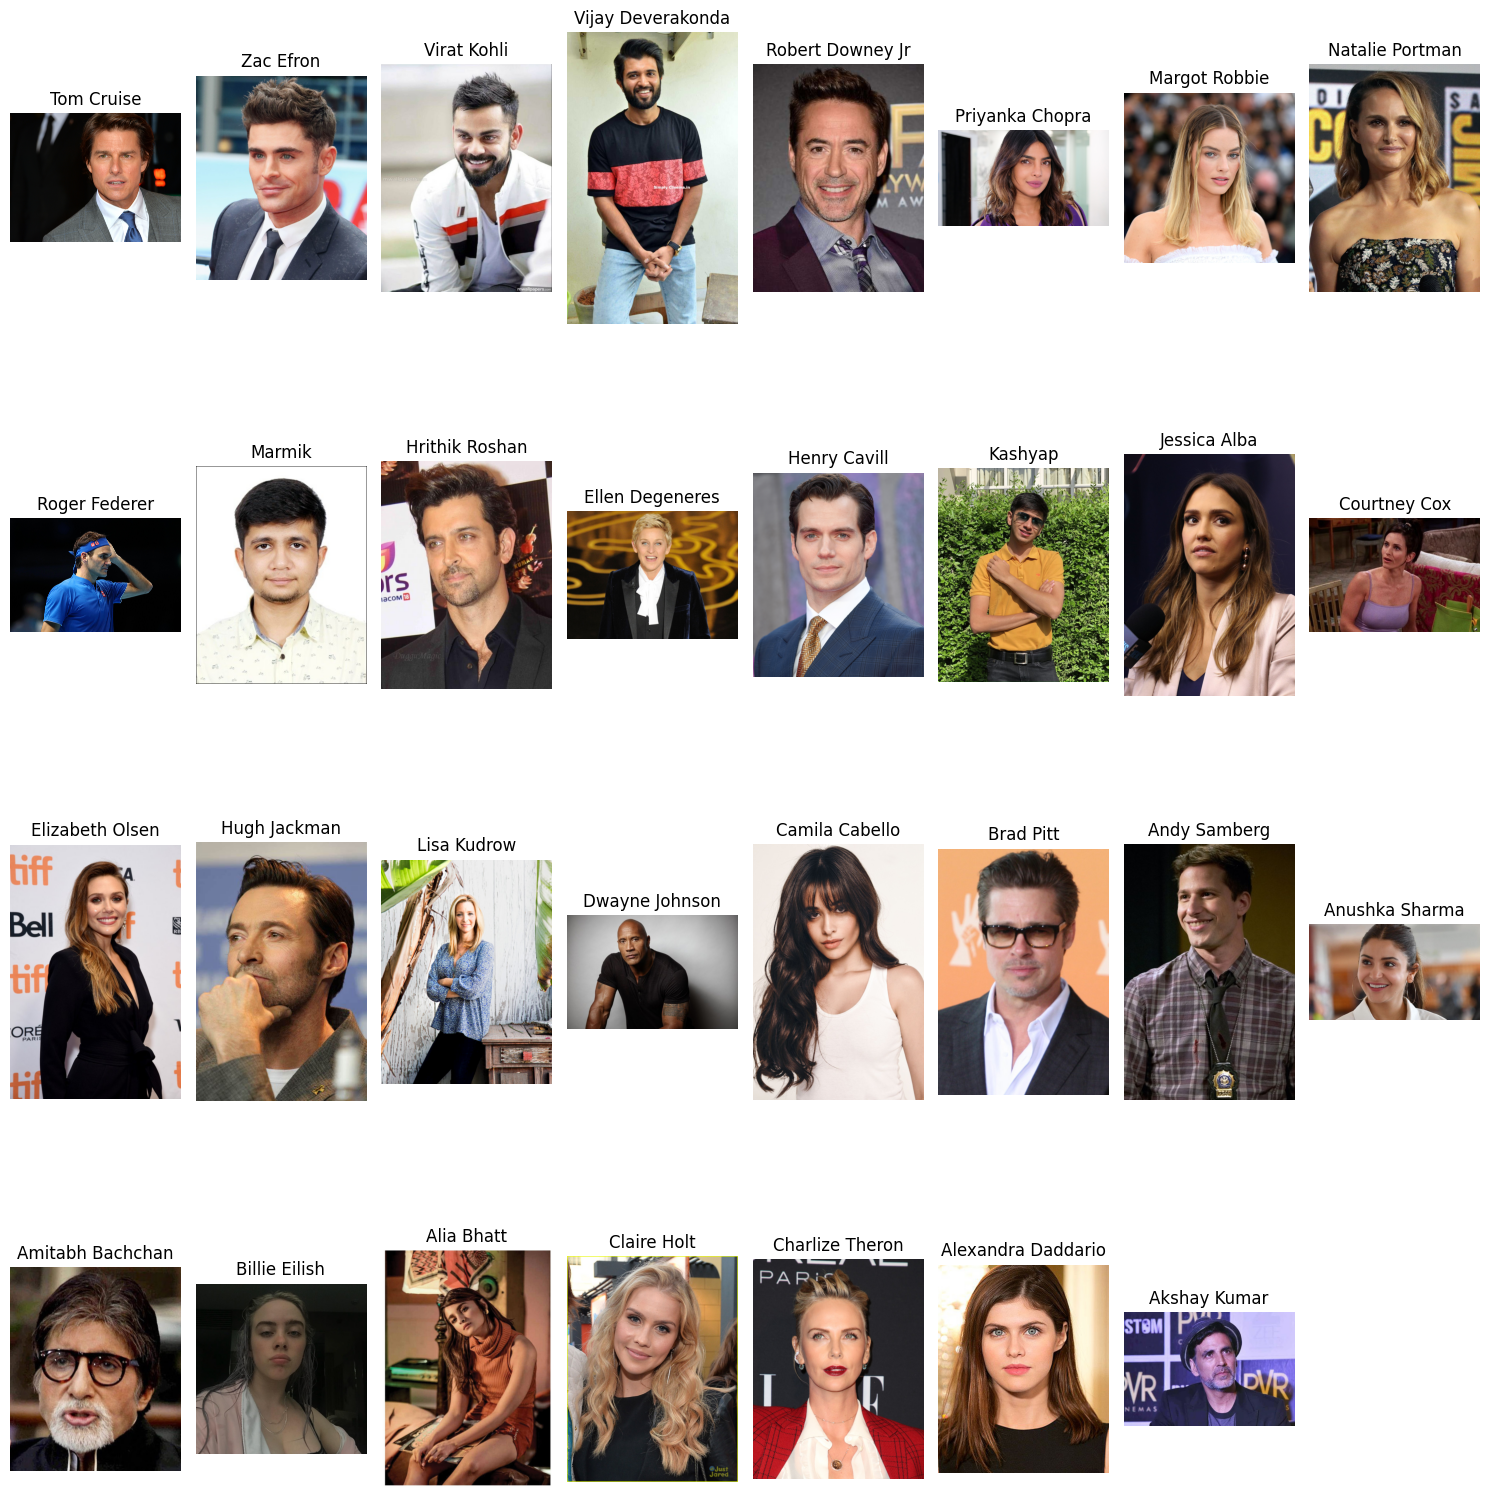

In [ ]:
actor_name = os.listdir(image_dir)

# Set up the plot
plt.figure(figsize=(15, 20))

# Loop through each actor's directory and plot an image
for i, actor_name in enumerate(actors):
    folder = os.path.join(image_dir, actor_name)

    # Ensure the folder is a directory and contains images
    if os.path.isdir(folder):
        # Get the list of image files in the directory
        image_files = os.listdir(folder)

        # Check if there are enough images in the directory
        if len(image_files) > 0:
            # Select an image (e.g., the first one for simplicity)
            img_path = os.path.join(folder, image_files[0])
            img = plt.imread(img_path)

            # Add the image to the subplot
            plt.subplot(5, 8, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(actor_name)
            plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Crop Images


In [ ]:
# Get the directory containing Haar cascade files
cascade_dir = cv2.data.haarcascades

# Path to the Haar cascade file for frontal face detection
cascade_file = os.path.join(cascade_dir, 'haarcascade_frontalface_default.xml')

# Check if the cascade file exists
if os.path.isfile(cascade_file):
    print("Haar cascade file found:", cascade_file)
else:
    print("Haar cascade file not found. Downloading...")
    cv2_base_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/"
    cascade_url = cv2_base_url + 'haarcascade_frontalface_default.xml'
    os.system(f"wget {cascade_url} -P {cascade_dir}")
    print("Haar cascade file downloaded successfully.")

# Now, you can use cascade_file as the filter_path in your code.
filter_path = cascade_file

Haar cascade file found: /usr/local/lib/python3.10/dist-packages/cv2/data/haarcascade_frontalface_default.xml


In [ ]:
# Function to detect faces and crop them from an image
def detect_and_crop_faces(image):
    face_cascade = cv2.CascadeClassifier(filter_path)
    faces = face_cascade.detectMultiScale(image, 1.3, 5)
    cropped_faces = []
    for (x, y, w, h) in faces:
        cropped_faces.append(image[y:y+h, x:x+w])
    return cropped_faces

In [ ]:
from sklearn.model_selection import train_test_split

# Path to the dataset directory
dataset_dir = ('/content/drive/MyDrive/dataset/Original Images/Original Images/')
# Path to store the cropped images
cropped_dataset_dir = ('/content/drive/MyDrive/dataset/Cropped Images/')
# Path to store the split train and test sets
train_dir = os.path.join(cropped_dataset_dir, "train")
test_dir = os.path.join(cropped_dataset_dir, "test")

# Create directories for train and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Common size to which all face images will be resized
common_size = (128, 128)

for subdir in os.listdir(dataset_dir):
    subdir_path = os.path.join(dataset_dir, subdir)
    if os.path.isdir(subdir_path):
        # Create corresponding subdirectories in train and test folders
        train_subdir_path = os.path.join(train_dir, subdir)
        test_subdir_path = os.path.join(test_dir, subdir)
        os.makedirs(train_subdir_path, exist_ok=True)
        os.makedirs(test_subdir_path, exist_ok=True)

        # Get the list of image files in the subdirectory
        image_files = [f for f in os.listdir(subdir_path) if f.endswith('.jpg')]

        # Iterate through each image in the subdirectory
        for image_name in image_files:
            image_path = os.path.join(subdir_path, image_name)
            # Read the image
            img = cv2.imread(image_path)
            # Detect and crop faces from the image (function detect_and_crop_faces to be defined)
            faces = detect_and_crop_faces(img)
            # Resize each face to a common size before appending to the list
            for idx, face in enumerate(faces):
                if face is not None:
                    resized_face = cv2.resize(face, common_size)
                    # Decide whether to put the image in train or test set
                    if np.random.rand() < 0.9:  # 90% train, 10% test
                        save_path = os.path.join(train_subdir_path, f"{image_name}_{idx}.jpg")
                    else:
                        save_path = os.path.join(test_subdir_path, f"{image_name}_{idx}.jpg")
                    # Save the cropped face image
                    cv2.imwrite(save_path, resized_face)
print('dataset created')

dataset created


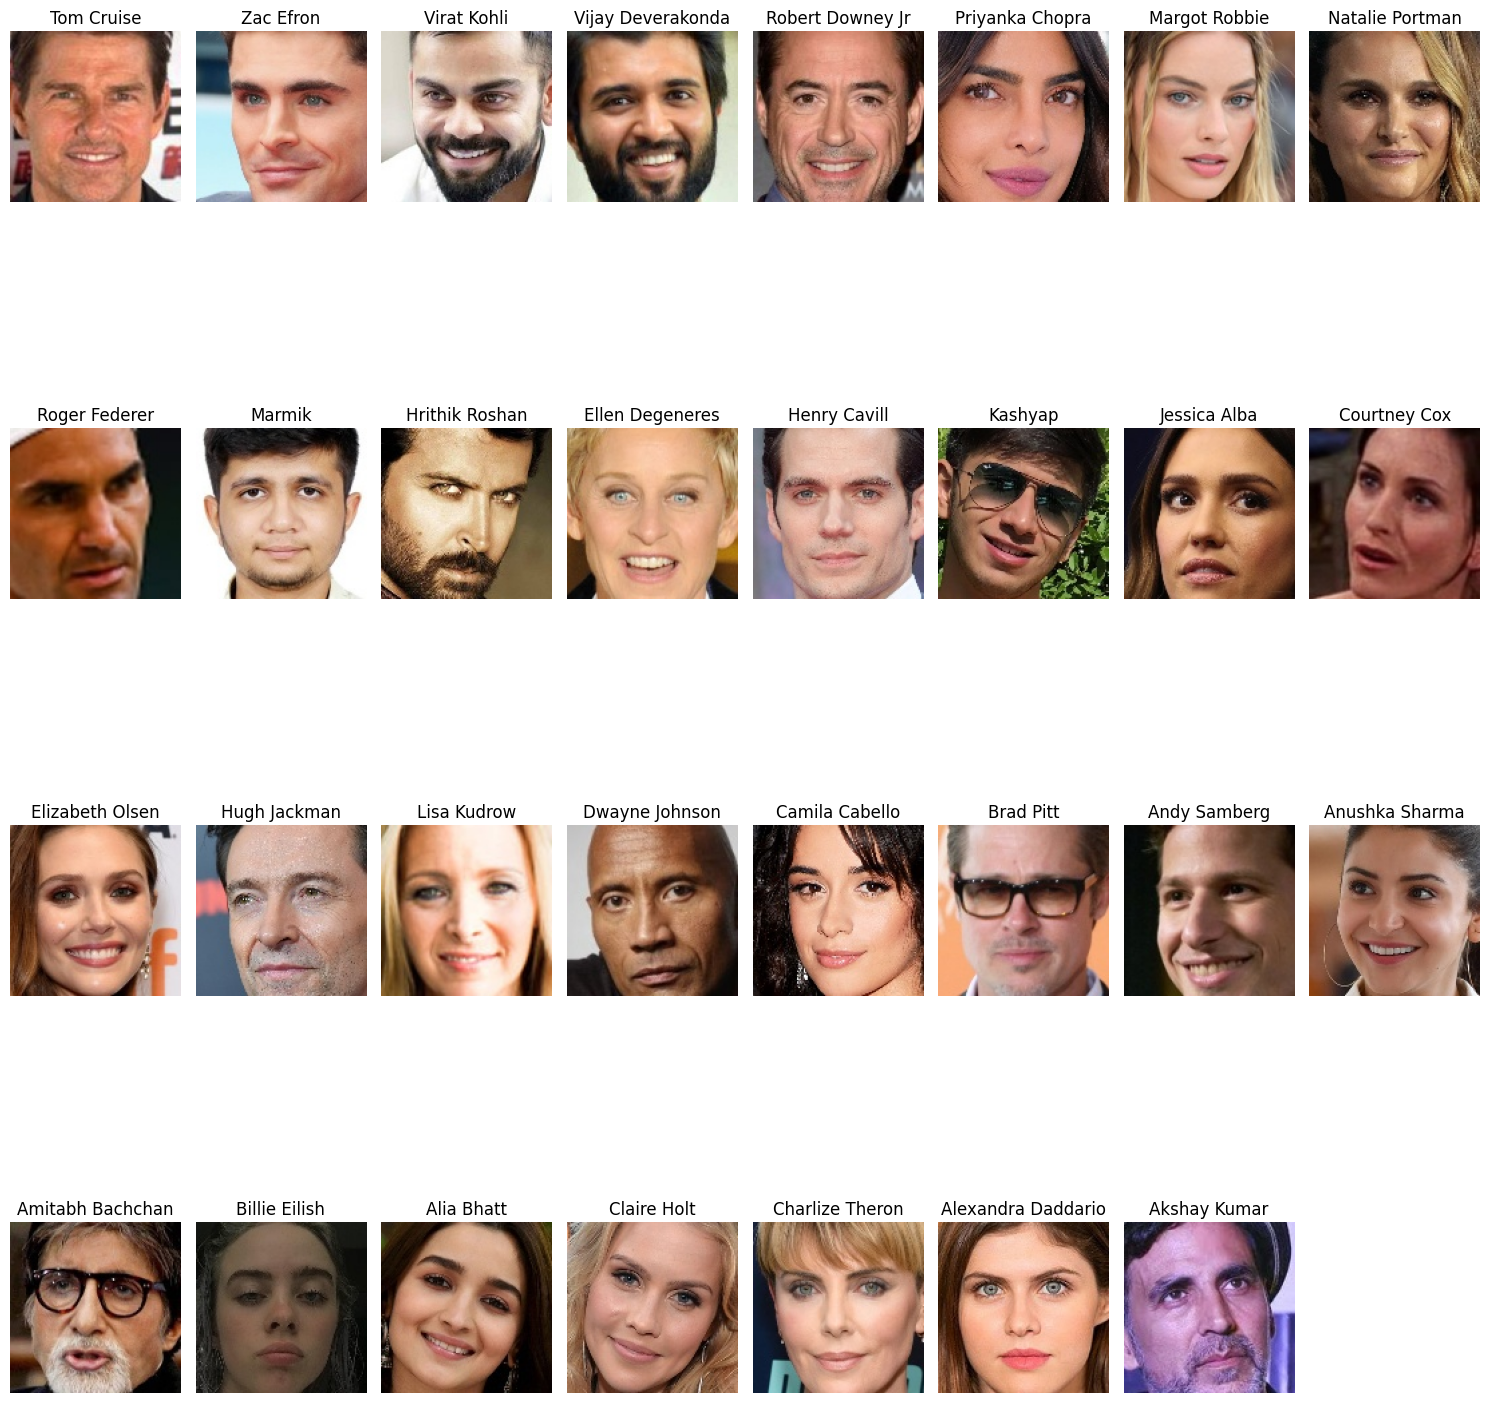

In [ ]:
cropped_images=('/content/drive/MyDrive/dataset/Cropped Images/train')
actor_name = os.listdir(cropped_images)

# Set up the plot
plt.figure(figsize=(15, 20))

# Loop through each actor's directory and plot an image
for i, actor_name in enumerate(actors):
    folder = os.path.join(cropped_images, actor_name)

    # Ensure the folder is a directory and contains images
    if os.path.isdir(folder):
        # Get the list of image files in the directory
        image_files = os.listdir(folder)

        # Check if there are enough images in the directory
        if len(image_files) > 0:
            # Select an image (e.g., the first one for simplicity)
            img_path = os.path.join(folder, image_files[0])
            img = plt.imread(img_path)

            # Add the image to the subplot
            plt.subplot(5, 8, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(actor_name)
            plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Data Preprocess


In [ ]:
train_dir=('/content/drive/MyDrive/dataset/Cropped Images/train')
test_dir=('/content/drive/MyDrive/dataset/Cropped Images/test')
# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(128,128),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=32,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(128,128),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=32  # Batch size for testing
                                                 )

Found 2237 images belonging to 31 classes.
Found 289 images belonging to 31 classes.


In [ ]:
# Get the list of classes
classes = list(train_generator.class_indices.keys())
print(classes)

['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.804032258064516, 1: 0.792981212336051, 2: 0.9885108263367212, 3: 1.3120234604105572, 4: 0.859062980030722, 5: 1.1101736972704714, 6: 1.2230727173318754, 7: 0.7216129032258064, 8: 1.045815801776531, 9: 0.9751525719267655, 10: 0.8200146627565983, 11: 0.8908801274392673, 12: 1.361533779671333, 13: 1.1101736972704714, 14: 1.0308755760368664, 15: 0.7759278529309747, 16: 0.9134340547162108, 17: 0.7439308280678417, 18: 0.662030186445694, 19: 1.4149272612270716, 20: 1.1101736972704714, 21: 1.0933528836754642, 22: 2.327783558792924, 23: 0.7289019224503095, 24: 0.7516801075268817, 25: 0.7005950516755403, 26: 1.5687237026647967, 27: 1.5033602150537635, 28: 0.902016129032258, 29: 2.255040322580645, 30: 0.9621505376344086}


# Modeling

In [ ]:
from tensorflow.keras.applications import ResNet50V2

ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(128,128,3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(31,activation='softmax')
                    ])
    return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 4, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [ ]:
os.makedirs('model_checkpoint', exist_ok=True)
cnn_path=('/content/drive/MyDrive/dataset/working/model_checkpoint')
name = 'ResNet50V2_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/drive/MyDrive/dataset/working/model_checkpoint/ResNet50V2_model.keras'

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')
# Callback for early stopping
earlystop = EarlyStopping(monitor='accuracy',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

callbacks = [checkpoint, earlystop]

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks)

Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 3.2380 - accuracy: 0.1323
Epoch 1: val_loss improved from inf to 44.45649, saving model to /content/drive/MyDrive/dataset/working/model_checkpoint/ResNet50V2_model.keras
70/70 [==============================] - 40s 352ms/step - loss: 3.2380 - accuracy: 0.1323 - val_loss: 44.4565 - val_accuracy: 0.0415
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 2.4200 - accuracy: 0.3026
Epoch 2: val_loss improved from 44.45649 to 2.55642, saving model to /content/drive/MyDrive/dataset/working/model_checkpoint/ResNet50V2_model.keras
70/70 [==============================] - 22s 320ms/step - loss: 2.4200 - accuracy: 0.3026 - val_loss: 2.5564 - val_accuracy: 0.2630
Epoch 3/50
70/70 [==============================] - ETA: 0s - loss: 1.9156 - accuracy: 0.4578
Epoch 3: val_loss did not improve from 2.55642
70/70 [==============================] - 20s 283ms/step - loss: 1.9156 - accuracy: 0.4578 - val_loss: 2.9703 - val

# Evaluate


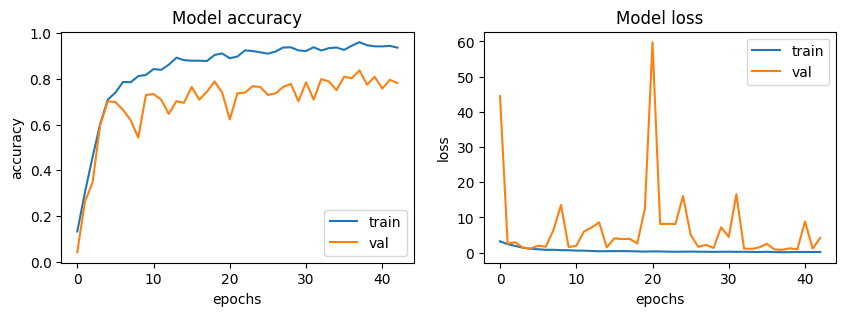

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training Accuracy: {train_accuracy*100: .2f}")

70/70 [==============================] - 19s 266ms/step - loss: 2.3787 - accuracy: 0.9700
Training Accuracy:  97.00


In [ ]:
model.save('ResNet50V2.h5')
from IPython.display import FileLink

# Create a download link
FileLink('ResNet50V2.h5')

/content/ResNet50V2.h5

10/10 [==============================] - 2s 111ms/step


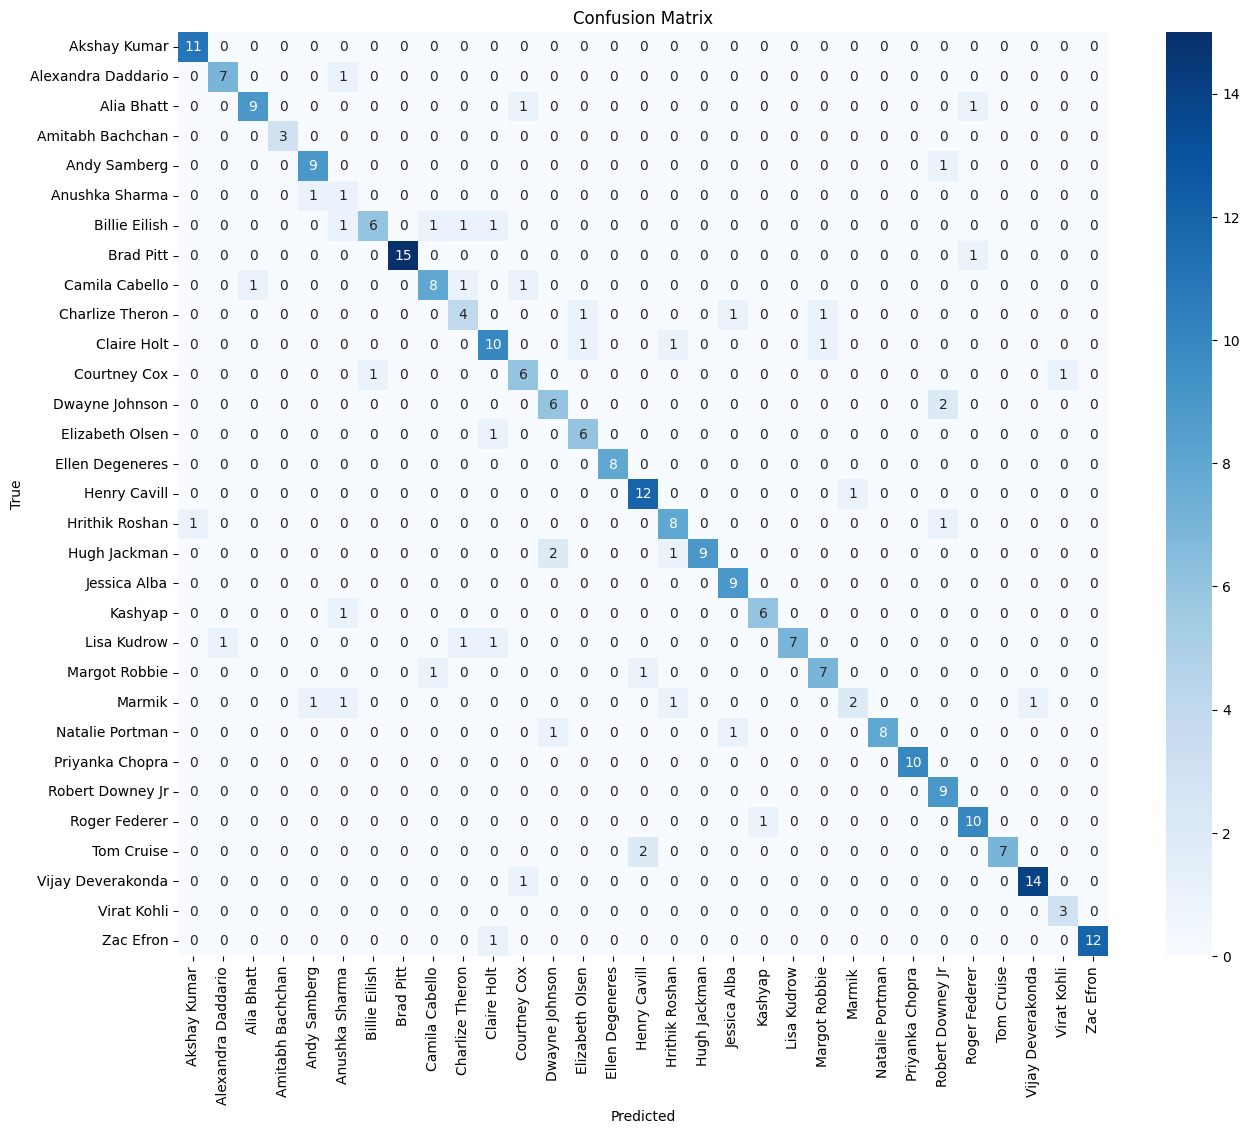

In [ ]:
import seaborn as sns
# Generate predictions for the test set
predictions = model.predict(test_generator)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class indices
true_classes = test_generator.classes

# Ensure that the number of true classes and predicted classes are the same
assert len(true_classes) == len(predicted_classes), "Mismatch in the number of samples between true and predicted classes"

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
class_labels = list(test_generator.class_indices.keys())

# Generate and print the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
                     precision    recall  f1-score   support

      Akshay Kumar       0.92      1.00      0.96        11
Alexandra Daddario       0.88      0.88      0.88         8
        Alia Bhatt       0.90      0.82      0.86        11
  Amitabh Bachchan       1.00      1.00      1.00         3
      Andy Samberg       0.82      0.90      0.86        10
    Anushka Sharma       0.20      0.50      0.29         2
     Billie Eilish       0.86      0.60      0.71        10
         Brad Pitt       1.00      0.94      0.97        16
    Camila Cabello       0.80      0.73      0.76        11
   Charlize Theron       0.57      0.57      0.57         7
       Claire Holt       0.71      0.77      0.74        13
      Courtney Cox       0.67      0.75      0.71         8
    Dwayne Johnson       0.67      0.75      0.71         8
   Elizabeth Olsen       0.75      0.86      0.80         7
   Ellen Degeneres       1.00      1.00      1.00         8
      Henry Cav

# Predicting a Random Image from the Internet

In [ ]:
import requests
from PIL import Image
import numpy as np
from io import BytesIO
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import load_model

# Function to download and preprocess the image
def preprocess_image(image_url, target_size):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize(target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# URL of the image to predict
image_url = 'https://assets.telegraphindia.com/telegraph/2023/Oct/1696677852_akshay-kumar.jpg'  # Replace with the actual URL

# Preprocess the image
input_shape = (128, 128)  # Make sure this matches your model's input shape
preprocessed_image = preprocess_image(image_url, target_size=input_shape)

# Load the saved model
model = load_model('/content/ResNet50V2.h5')

# Make a prediction
predictions = model.predict(preprocessed_image)

# Decode the predictions
predicted_class = class_labels[np.argmax(predictions)]
confidence_score = np.max(predictions)

# Print the predictions
print(f"Predicted class: {predicted_class} with confidence score: {confidence_score * 100:.2f}%")

1/1 [==============================] - 1s 915ms/step
Predicted class: Akshay Kumar with confidence score: 69.64%
